In [1]:
%matplotlib inline
#import stripe82
import aplpy
from qso_fit import qso_fit
from astropy.io.votable import parse_single_table
import numpy as np
from astropy.cosmology import WMAP5
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import stats
import matplotlib as mpl
import matplotlib.image as mpimg
from scipy.optimize import nnls
from PyAstronomy import pyasl
import glob, os
from scipy import interpolate
from astropy.time import Time
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
#from javelin.zylc import get_data
#from javelin.lcmodel import Cont_Model
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings("ignore")

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1069: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Applications/anaconda/lib/python2.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'cairo', u'MacOSX', u'CocoaAgg', u'gdk', u'ps', u'GTKAgg', u'nbAgg', u'GTK', u'Qt5Agg', u'template', u'emf', u'GTK3Cairo', u'GTK3Agg', u'WX', u'Qt4Agg', u'TkAgg', u'agg', u'svg', u'GTKCairo', u'WXAgg', u'WebAgg', u'pdf']
  (val, error_details, msg))


[34.593803] [-4.509953]
-3.6287168759968806


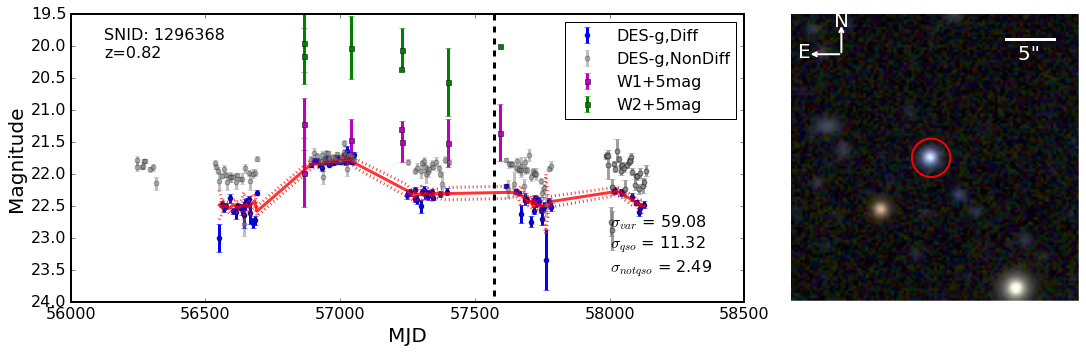

In [18]:
#domo the light curve for single object (corrected 2019)
# plot examples and original flux calibration test for 1279780 (a SN) 
cat_result=fits.open('../ALL_31642_lite.fits')
cat=cat_result[1].data

name='1296368' #34.593838,-4.5099669
#

#name='1279780'# SN for test
idx=np.where(cat['SNID'] == name,True,False)
print cat['ra'][idx],cat['dec'][idx]


file='../data/all_real_lc/des_real_0'+name+'.dat'
data=np.genfromtxt(file,skip_header =70,usecols=(1,2,3,4,5,6),
                  dtype=(float,'S32','S32',float,float,int),
                  names=['MJD','FLT', 'FIELD', 'FLUXCAL','ERR','flag']) 

host_mag_g=cat['host_g'][idx]
#print host_mag_g

ff=10**((host_mag_g-27.5)/-2.5) # mag to flux

ind=np.where( (data['FLT'] == 'g' ) & ( abs(data['ERR']/data['FLUXCAL']) <0.3) & ((data['FLUXCAL']+ff) >0),True,False)


mag=-2.5*np.log10((data['FLUXCAL'][ind])+ff)+27.5
magerr=-2.5*np.log10((data['FLUXCAL'][ind])+data['ERR'][ind]+ff)+27.5-mag
mjd=data['MJD'][ind]

re=qso_fit(mjd, mag,magerr,filter='g',return_model=True)
print re['lvar']

fig=plt.figure(figsize=(16,5))
plt.subplots_adjust(left=.1, bottom=.15, right=.99, top=.95)
ax=plt.subplot(1,6,(1,4))
plt.style.use('my')
plt.errorbar(mjd,mag,yerr=magerr,fmt='o',ms=5,label='DES-g,Diff')
plt.plot(mjd,re['model'],'r-',alpha=0.8)
plt.plot(mjd,re['model']+re['dmodel'],'r:',alpha=0.8)
plt.plot(mjd,re['model']-re['dmodel'],'r:',alpha=0.8)

plt.gca().invert_yaxis()
plt.xlabel('MJD')
plt.ylabel('Magnitude')
#plt.xlim(57000,57300)
#plt.ylim(26,20)
plt.text(0.05,0.85,'SNID: '+name+'\nz=0.82',transform=ax.transAxes,fontsize=16)
plt.text(0.8,0.1,r'$\sigma_{var}$ = '+str(np.round(re['signif_vary'],2))+
         '\n$\sigma_{qso}$ = '+str(np.round(re['signif_qso'],2))+
         '\n$\sigma_{notqso}$ = '+str(np.round(re['signif_not_qso'],2)),
         transform=ax.transAxes,fontsize=16)

#plot the orignal 
g=np.genfromtxt('../j0218/g_Y5.txt',delimiter=',')
plt.errorbar(g[:,0],g[:,1],yerr=g[:,2],fmt='o',color='grey',markersize=5,label='DES-g,NonDiff',alpha=0.5)


#plot wise
wise=fits.open('../wise_lc_2arc.fits')[1].data
plt.errorbar(wise['mjd'],wise['w1mpro']+5,yerr=wise['w1sigmpro'],fmt='s',markersize=5,label='W1+5mag',color='m')
plt.errorbar(wise['mjd'],wise['w2mpro']+5,yerr=wise['w2sigmpro'],fmt='s',markersize=5,label='W2+5mag')

'''
#plot PS
ps2=fits.open('../PS2_LC.fits')[1].data
for i in zip([1,3],['c','purple'],['PS-g','PS-i']):
    indg=np.where(ps2['filterid'] == i[0],True,False)
    psmag= -2.5*np.log10(ps2['psfflux'][indg])+8.98   #AB system
    psmagerr=-2.5*(np.log10(ps2['psfflux'][indg])-np.log10(ps2['psfflux'][indg]+ps2['psffluxerr'][indg]))
    plt.errorbar(ps2['obsTime'][indg],psmag,yerr=psmagerr,fmt='s',color=i[1],markersize=5,label=i[2])
plt.plot([56291],[21.78],'r*',label='PS Median')
'''


#plt.plot([51762,51762],[19.5,24.],'k:')
#plt.plot([54107,54107],[19.5,24.],'k:')
#plt.plot([54832,54832],[19.5,24.],'k:')
#plt.plot([57755,57755],[19.5,24.],'k:')
plt.plot([57570,57570],[19.5,24.],'k--')
plt.legend(numpoints=1,fontsize=16)

#-----------image -------------------------------
import matplotlib.image as mpimg

ax2=plt.subplot(1,6,(5,6))
#plt.subplot(131)
##from coadd web
#img=mpimg.imread('./image/DESJ021822.5-043035.8_coadd.png')
#imgplot = plt.imshow(img)
#plt.axis('off')

img=mpimg.imread('./image/DESJ021822.5-043035.8_coadd_deep.png')
imgplot = plt.imshow(img)

plt.plot([85,104],[10,10],'white') #1" = 3.8 pixels   1" = 7.67 kpc 
circle1 = plt.Circle((55.5, 57), 7.6, color='r',fill=False,lw=2)
ax2.add_artist(circle1)
plt.text(90,18,'5" ',color='white',fontsize=20)
plt.axis('off')
plt.xlim(0,114)
plt.ylim(114,0)
x=20
y=16
plt.annotate("", xy=(x, 4), xytext=(x,y), arrowprops=dict(arrowstyle="->",color='white',lw=2))
plt.annotate("", xy=(7, y), xytext=(x,y), arrowprops=dict(arrowstyle="->",color='white',lw=2))
plt.text(17,5,"N",color='white',fontsize=20)
plt.text(3,17,"E",color='white',fontsize=20)

#plt.savefig('../paper_figure_j0218/des_coadd.png')
#plt.subplot(133)
#from coadd by irg 
#img=mpimg.imread('./image/3color_irg/DESJ021822.5127-043035.8308.png')
#imgplot = plt.imshow(img)
#plt.axis('off')

plt.savefig('../paper_figure_j0218/diffimg_lc.pdf')


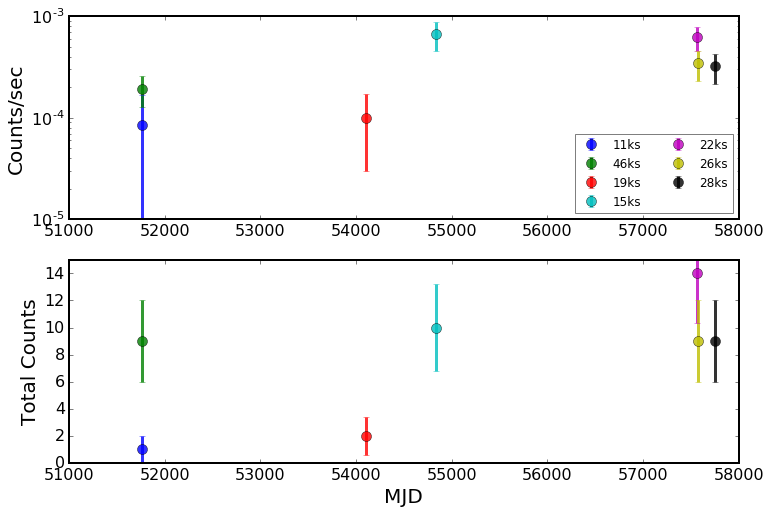

In [37]:


mjd=np.array([51762,51763,54107,54832,57570,57571,57755])
exp=np.array([11812,46813,19869,15023,22500,26100,28000])
counts=np.array([1.,9.,2.,10.,14.,9.,9.])
err=np.array([1.,3.,1.4,3.2,3.7,3.,3.])
plt.figure(figsize=(12,8))
plt.style.use('my')
plt.subplot(211)

for i in range(7):
    plt.errorbar(mjd[i],counts[i]/exp[i],yerr=err[i]/exp[i],fmt='o',alpha=0.8,label=str(exp[i]/1000)+'ks')
plt.legend(numpoints=1,ncol=2,loc=4,framealpha=0.5)
plt.yscale('log')
plt.ylabel('Counts/sec')


plt.subplot(212)
#plt.errorbar(mjd,counts,yerr=err,color='grey',fmt='o',alpha=0.8)
#plt.yscale('log')
for i in range(7):
    plt.errorbar(mjd[i],counts[i],yerr=err[i],fmt='o',alpha=0.8,label=str(exp[i]/1000)+'ks')

plt.ylabel('Total Counts')
plt.xlabel('MJD')
plt.ylim(0,15)
plt.savefig('/Users/legolason/Desktop/x-var.pdf')

198 354
155 43
(8026,) (403,) (671,) (354,) (198,)


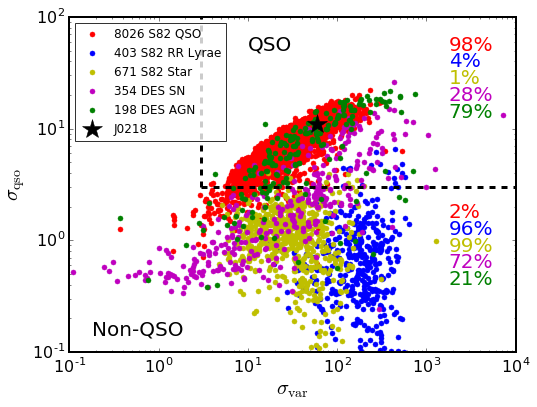

In [104]:
qso=fits.open('../lc_fit/ALL_stripe82.fits')
star=fits.open('../lc_fit/ALL_stripe82_RRlyr.fits')
va=fits.open('../lc_fit/ALL_31642_lite_bulter.fits')
ss=fits.open('../lc_fit/ALL_stripe82_star.fits')

q=qso[1].data
s=star[1].data # RR star
v=va[1].data
s1=ss[1].data

#agn=np.where(v['oztype'] > '-1', True, False)
agn=np.where( ((v['oztype'] == 'AGN_monitoring') | (v['oztype'] == 'AGN_reverberation')) & (v['npt'] >= 10) ,True,False)
sn=np.where(v['sntype']==1,True,False)
print np.sum(agn),np.sum(sn)
plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.loglog(q['sig'],q['sigqso'],'r.',label='8026 S82 QSO')
id1 = np.where( (q['sig'] > 3) & (q['sigqso']>3),True,False) 
#print np.sum(id1),np.sum(~id1) #98% 2%
plt.loglog(s['sig'],s['sigqso'],'b.',label='403 S82 RR Lyrae')
id1 = np.where( (s['sig'] > 3) & (s['sigqso']>3),True,False) 
#print np.sum(id1),np.sum(~id1) #96 4%
plt.loglog(s1['sig'],s1['sigqso'],'y.',label='671 S82 Star')
id1 = np.where( (s1['sig'] > 3) & (s1['sigqso']>3),True,False) 
#print np.sum(id1),np.sum(~id1) #99 1%
plt.loglog(v['sig'][sn],v['sigqso'][sn],'m.',label='354 DES SN')
id1 = np.where( (v['sig'][sn] > 3) & (v['sigqso'][sn]>3),True,False) 
#print np.sum(id1),np.sum(~id1) #72 28%
plt.loglog(v['sig'][agn],v['sigqso'][agn],'g.',label='198 DES AGN')
id1 = np.where( (v['sig'][agn] > 3) & (v['sigqso'][agn]>3),True,False) 
print np.sum(id1),np.sum(~id1) #79 21%
#plt.loglog(v['sig'],v['sigqso'],'c.',label='DES AGN')
print q['sig'].shape,s['sig'].shape,s1['sig'].shape,v['sig'][sn].shape,v['sig'][agn].shape

plt.ylim(0.1,100)
plt.xlim(0.1,10000)

#x=np.arange(0,2.5,0.01)
#plt.plot([3,3],[3,100],'k')
#plt.plot([3,20],[3,3],'k')
#x1=np.arange(10**1.3,10**4,1)
#plt.plot(x1,10**(0.56*np.log10(x1)-0.24),'k')  # logy > 0.56logx -0.24

plt.plot([3,3],[3,100],'k--')
plt.plot([3,10000],[3,3],'k--')
plt.xlabel(r'$\rm \sigma_{var} $')
plt.ylabel(r'$\rm \sigma_{qso}$')
plt.plot([59],[11],'k*',label='J0218',markersize=20)

plt.legend(fontsize=12,numpoints=1,loc='best',framealpha=0.8)


inagn=np.where( ((v['oztype'] == 'AGN_monitoring') | (v['oztype'] == 'AGN_reverberation'))& (v['npt']>=10)&
    (v['sigqso'] > 3.) & (v['sig'] > 3.), True,False)
insn=np.where( (v['sntype']==1) &(v['sigqso'] > 3.) & (v['sig'] > 3.)& 
                 ((np.log10(v['sigqso']) > (0.56*np.log10(v['sig'])-0.24)) ), True,False)
inrr=np.where((s['sigqso'] > 3.) & (s['sig'] > 3.)& 
              ((np.log10(s['sigqso']) > (0.56*np.log10(s['sig'])-0.24)) ), True,False)
instar=np.where((s1['sigqso'] > 3.) & (s1['sig'] > 3.)& 
                ((np.log10(s1['sigqso']) > (0.56*np.log10(s1['sig'])-0.24)) ), True,False)

plt.text(0.4,0.9,'QSO',transform=ax.transAxes,fontsize=20)
plt.text(0.05,0.05,'Non-QSO',transform=ax.transAxes,fontsize=20)

plt.text(0.85,0.9,'98%',color='r',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.85,'4%',color='b',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.80,'1%',color='y',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.75,'28%',color='m',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.7,'79%',color='g',transform=ax.transAxes,fontsize=20)
n=0.5
plt.text(0.85,0.9-n,'2%',color='r',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.85-n,'96%',color='b',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.80-n,'99%',color='y',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.75-n,'72%',color='m',transform=ax.transAxes,fontsize=20)
plt.text(0.85,0.7-n,'21%',color='g',transform=ax.transAxes,fontsize=20)


#print np.sum(~inrr),np.sum(~instar), np.sum(inagn),np.sum(insn)

plt.savefig('../paper_figure_j0218/variability_selection.pdf')


(105783, 5) [16.564 15.11  12.549  8.072]
(1000,) (2049,)


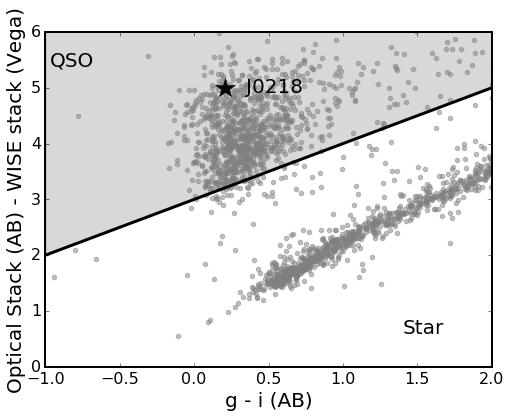

In [103]:
dr7=fits.open('../../dr14q/catalog/dr7_bh_Nov19_2013.fits')[1].data
print dr7['UGRIZ'].shape,dr7['WISE1234'][0]
n=1000
nn=8
x=dr7['ugriz'][:n,1]-dr7['ugriz'][:n,3]
y=(dr7['ugriz'][:n,1]+0.8*dr7['ugriz'][:n,2]+0.6*dr7['ugriz'][:n,3])/2.4-(dr7['WISE1234'][:n,0]+0.5*dr7['WISE1234'][:n,1])/1.5

plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.scatter(x,y,color='grey',alpha=0.5)
x1=np.linspace(-1,2,100)
plt.plot(x1,x1+3,'k')
plt.xlim(-1,2)
plt.ylim(0,6)


ax.fill_between(x1, 6, x1+3,facecolor='grey',alpha=0.3)


image=fits.open('./colorcut/SDSS_WISE_colorcut.fits')[1].data
ind=np.where(image['type'] ==6,True,False)
x2=image['psfMag_g'][ind]-image['psfMag_i'][ind]
y2=(image['psfMag_g'][ind]+0.8*image['psfMag_r'][ind]+0.6*image['psfMag_i'][ind])/2.4-\
(image['w1mpro'][ind]+0.5*image['w2mpro'][ind])/1.5
plt.scatter(x2,y2,color='grey',alpha=0.5)

plt.xlabel("g - i (AB)")
plt.ylabel("Optical Stack (AB) - WISE stack (Vega)")
plt.text(0.01,0.9,'QSO',color='k',transform=ax.transAxes,fontsize=20)
plt.text(0.8,0.1,'Star',color='k',transform=ax.transAxes,fontsize=20)
plt.text(0.45,0.82,'J0218',color='k',transform=ax.transAxes,fontsize=20)

plt.plot([0.21],[5],'k*',markersize=20)
plt.savefig('../paper_figure_j0218/optical_MIR_color.pdf')
print x.shape,x2.shape


[1.47697895e-11 0.00000000e+00 5.95017593e-11 0.00000000e+00]
2.0083019483225257
-20.357425120912517
10.692970048365005
44.55271635566159
0.9989315292928392


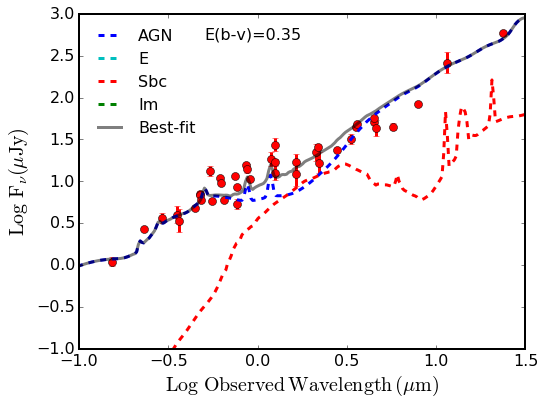

In [620]:
# -------read orignial data-----
plt.figure(figsize=(8,6))
table = parse_single_table('./sed/vizier_votable.vot')
wave=np.log10(3.e14/(table.array['sed_freq']*10**9))      #Ghz to hz to um
flux=np.log10(table.array['sed_flux']*1.e6)           # ujy
error=np.log10(table.array['sed_flux']+table.array['sed_eflux'])-np.log10(table.array['sed_flux'])

wv,ind=np.unique(wave,return_index=True)
f,err=flux[ind],error[ind]

ind=np.where(f[0:-7]<3,True,False)
wv=wv[0:-7][ind]
f=f[0:-7][ind]
err=err[0:-7][ind]
#plt.errorbar(wv,f,yerr=err,fmt='o',color='b',ms=8)

#------read selected data--------
data=np.genfromtxt('./sed/vizier_votable.csv',delimiter=',')
#wv=np.log10(3.e14/(data[:,0]*10**9))      #Ghz to hz to um
#f=np.log10(data[:,1]*1.e6)           # ujy
#err=np.log10(data[:,1]+data[:,2])-np.log10(data[:,1])



#-----------do the reddening for the AGN templete-----
# read templete and use non-negetive lsq to find the best model
tem=np.genfromtxt('./sed/assef2010_templete.txt')
wv1 = np.log10(tem[:,0])+np.log10(1.82) # log um

smc=np.genfromtxt('./sed/smc.txt') #um
fdust=interpolate.interp1d(smc[:,0],smc[:,2],bounds_error=False,fill_value=0)
smc_n=fdust(tem[:,0])
Ebv=0.35
AGN_redden=np.log10(tem[:,1]*1.e12/(2.512**(smc_n*Ebv)))
AGN=AGN_redden
#plt.plot(np.log10(tem[:,0]),(np.log10(tem[:,1]*1.e+12)))
#plt.plot(np.log10(tem[:,0]),AGN_redden)
E=np.log10(tem[:,3])+7
Sbc=np.log10(tem[:,4])+6
Im=np.log10(tem[:,5])+8


f1= interpolate.interp1d(wv1, AGN,bounds_error=False)
f2= interpolate.interp1d(wv1, E,bounds_error=False)
f3= interpolate.interp1d(wv1, Sbc,bounds_error=False)
f4= interpolate.interp1d(wv1, Im,bounds_error=False)
wv=np.array(wv)
AGN_n=f1(wv)
E_n=f2(wv)
Sbc_n=f3(wv)
Im_n=f4(wv)

flux_temp=np.vstack((10**AGN_n,10**E_n,10**Sbc_n,10**Im_n))

res=nnls(flux_temp.T, 10**f)[0]
print res


plt.errorbar(wv,f,yerr=err,fmt='o',color='r',ms=8,alpha=1)
plt.plot(wv1,np.log10(10**AGN*res[0]),'b--',label='AGN')
plt.plot(wv1,np.log10(10**E*res[1]),'c--',label='E')
plt.plot(wv1,np.log10(10**Sbc*res[2]),'r--',label='Sbc')
plt.plot(wv1,np.log10(10**Im*res[3]),'g--',label='Im')

total=np.log10(10**np.log10(10**AGN*res[0])+10**np.log10(10**E*res[1])+10**np.log10(10**E*res[2]*0.4)+10**np.log10(10**Im*res[3]))
#print total
plt.plot(wv1,total,'k',label='Best-fit',alpha=0.5)

plt.legend(loc='best',frameon=False,fontsize=16)
plt.text(-0.3,2.7,'E(b-v)=0.35',fontsize=16)

plt.xlim(-1.,1.5)
plt.ylim(-1,3)
plt.xlabel(r"$\rm Log\,\,Observed\, Wavelength\, (\mu m)$")
plt.ylabel(r'$\rm Log\,\,F_{\nu} (\mu Jy)$')


#calculate Mstellar ---------with taylor 2011-------

wave=10**wv1*1.e4
flux=(10**Sbc*res[2]) # ujy
#plt.plot(10**wv1*1.e4,np.log10(10**Sbc*res[2]),'r--',label='Sbc')
#plt.xlim(3000,8000)

f_g=flux[94] #4770
f_i=flux[114] #7625

mag_g = -2.5*np.log10(f_g/3631.e6)
mag_i = -2.5*np.log10(f_i/3631.e6)
DL = 5263.8 *1.e6 #pc
Mi=mag_i-5*np.log10(DL)+5
print mag_g-mag_i
print Mi
g_i=2
Mstellar=1.15+0.7*g_i-0.4*Mi
print Mstellar
#plt.plot([-0.32,-0.32],[-1,3],'k:')
#plt.plot([-0.11,-0.11],[-1,3],'k:')
plt.savefig('../paper_figure_j0218/sed.pdf')

#accretion rate mdot
Lbol=np.log10(0.7e-17*12.56*(DL*3.08e18)**2*3000)+np.log10(5.15)
print Lbol
Mbh=6.5
mdot=Lbol/(np.log10(1.26e38)+Mbh)
print mdot 
